# Book Recommendation for Readers
### By Ludmila Mucavele

## Content
1.  [Dataset Introduction](#1)
2. [Data Gathering and Cleaning](#2)
3. [Exploratory Data Analysis](#3)
4. [Collaborative filtering based on books Similarity](#4)
   * [4.1. Collaborative Filtering using Cosine Similarity](#4.1)
   
   
5. [Recommendation](#5)

<a id = 1></a>
## 1. Dataset Introduction
The dataset contains information about books and how users interacted with them by ratings. It contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

The data set can be found <a href="https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset">here</a>.

This Book-Crossing dataset comprises 3 files:

* Users : That contains the users data. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.
* Books: That are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided.
* Ratings: That contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

The datasets were collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems.


The data provided will be used to create a recommendation system which uses the books data (such as	Year-Of-Publication, average rating and user ratings), to recommend for future books to read based on the similarity of the content between the book choosen and others.

#### Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

<a id = 2></a>
## 2. Data Gathering and Cleaning
Let's start with collecting and cleaning the data for training and testing in the model.

In [2]:
books = pd.read_csv('./Data/Books.csv', usecols = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher'])
ratings = pd.read_csv('./Data/Ratings.csv')
users = pd.read_csv('./Data/Users.csv')
print('Books:', books.shape, '\nRatings:', ratings.shape, '\nUsers:', users.shape)

C:\Users\ludmi\AppData\Local\Temp\ipykernel_14932\3308639499.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('./Data/Books.csv', usecols = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher'])


Books: (271360, 5) 
Ratings: (1149780, 3) 
Users: (278858, 3)


In [3]:
print(books.info(), ratings.info(), users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column

In [4]:
#Fix the columns dtypes
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
books = books.dropna(subset=['Year-Of-Publication'])
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int
                                                                  )
books['ISBN'], ratings['ISBN'] = books['ISBN'].astype(object), ratings['ISBN'].astype(object)

books['Book-Title'] = books['Book-Title'].astype(object)

books['Book-Author'] = books['Book-Author'].astype(object)

books['Publisher'] = books['Publisher'].astype(object)

In [5]:
# Cleaning books with non-existing years

# For books dataset
books_1 = books.loc[(books['Year-Of-Publication'] >= 2022) | (books['Year-Of-Publication'] == 0)]
isbn = books_1.ISBN
books.drop(isbn.index, axis = 0, inplace = True)
books = books.reset_index(drop=True)

# For ratings dataset
idx = ratings[ratings.ISBN.isin(isbn)].index
ratings.drop(idx, axis = 0, inplace = True)
ratings = ratings.reset_index(drop=True)


In [6]:
print('Books:', books.shape, '\nRatings:', ratings.shape, '\nUsers:', users.shape)

Books: (266726, 5) 
Ratings: (1135717, 3) 
Users: (278858, 3)


<a id = 3></a>
## 3. Exploratory Data Analysis

First, let's merge all the datasets into one, and look for the correlation betweet the variables.

In [7]:
# merge books and ratings dataset based on the book ISBN
df = books.merge(ratings, how = 'left').merge(users, how = 'left')

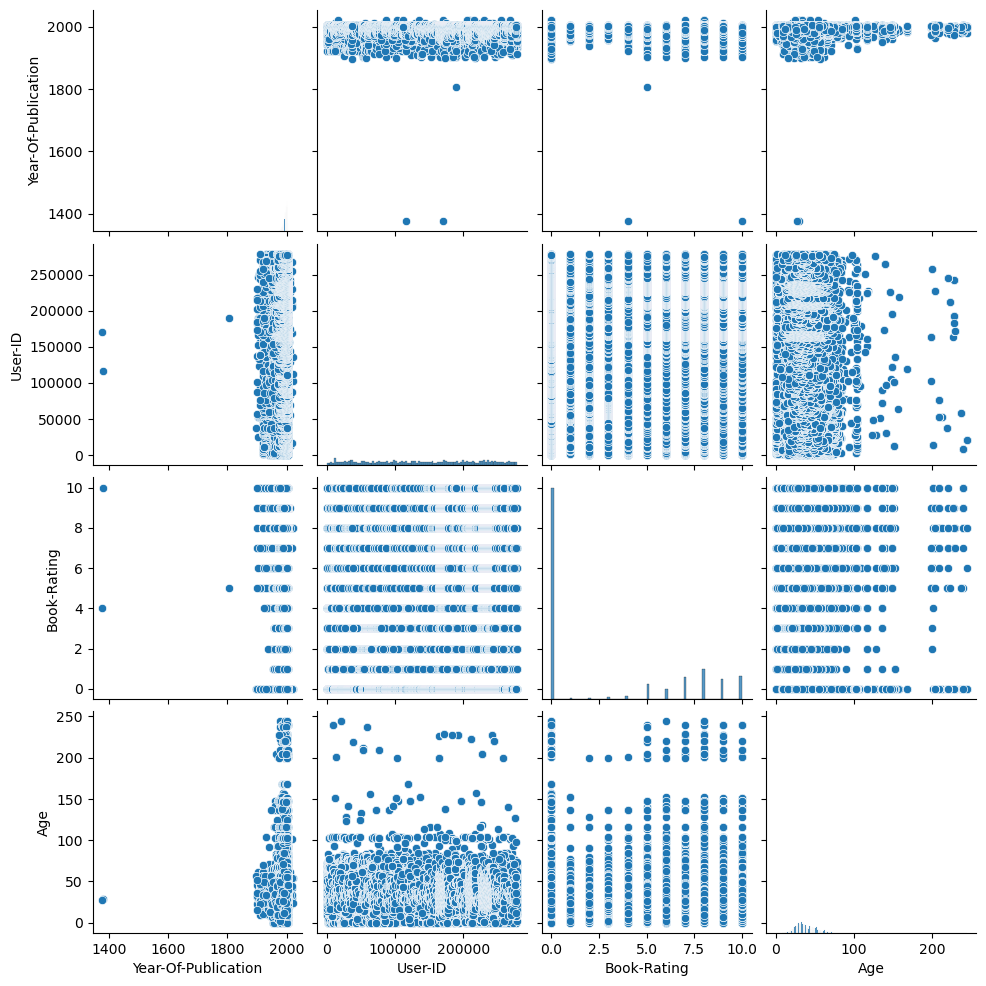

In [8]:
sns.pairplot(data = df);

As we can see, there is no correlation between the datasets numeric variables, but it does not mean that we can not build the system based on the books similarity, once the idea of collaborative filtering is based on users who have similar preferences in the past and should have similar preferences in the future. This approach of using collaborative filtering is used exactly because the dataset variables do not have a specific correlation between them.

For knowing better the data, let's now see the count of books based on their year of publication.

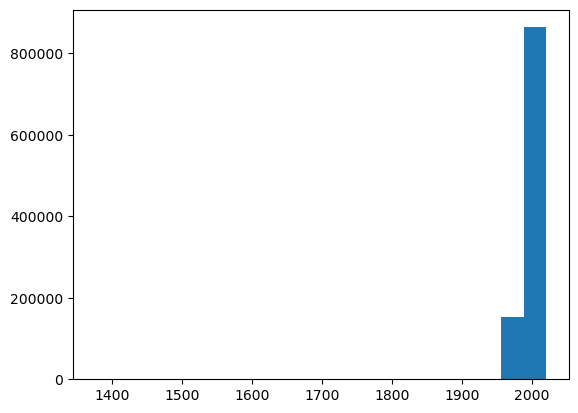

In [9]:
plt.hist(data = df, x = 'Year-Of-Publication', bins = 20);

A more detailed visualization of the plot:

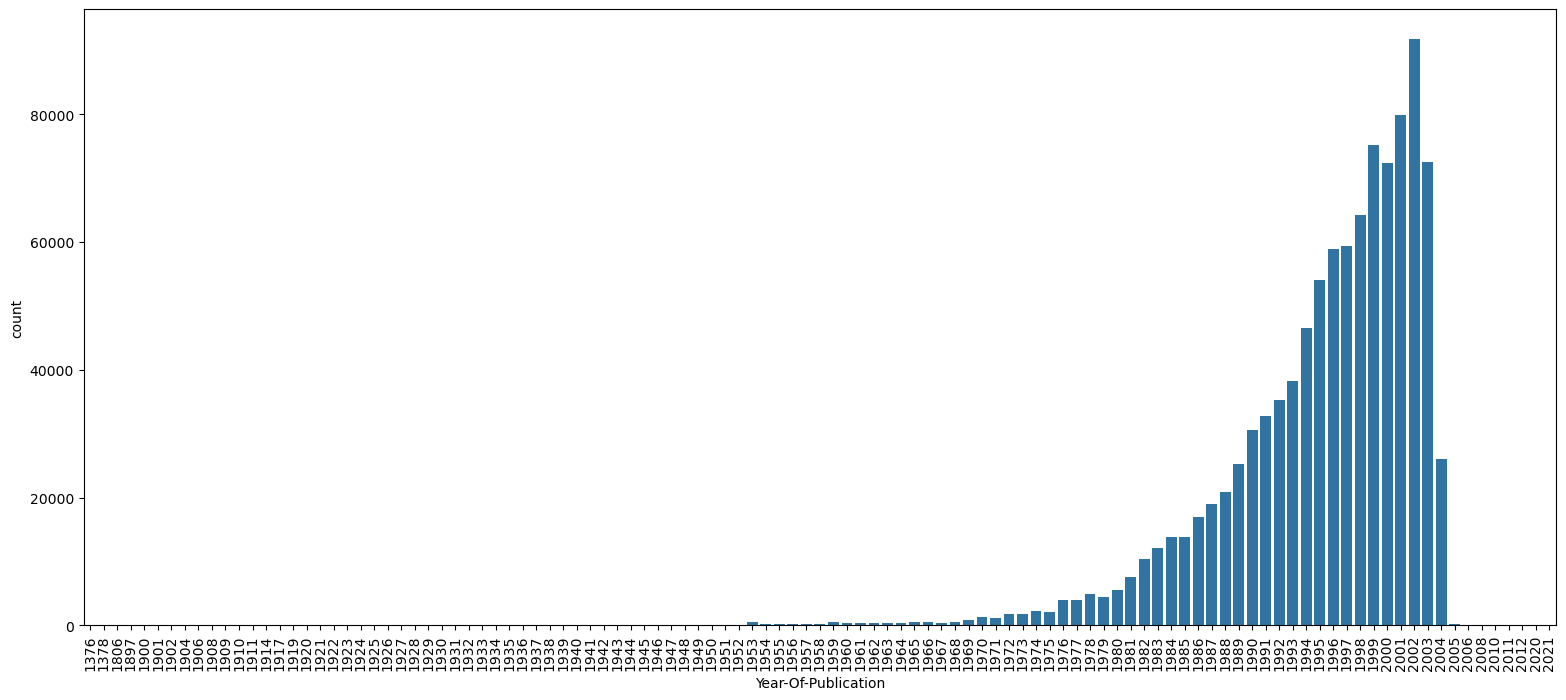

In [10]:
plt.figure(figsize = (19, 8))
sns.countplot(data = df, x = 'Year-Of-Publication', color = sns.color_palette()[0])
plt.xticks(rotation = 90);

The plot is skewed to the right, which shows that there might be some outliers, that are the very few books before 1970 year.

That being said, it is better to filter the books that have more ratings from users than to keep books that has very few readers or even no ratings. This process will be done further, when pre-processing the data.

<a id = 4></a>
##  4. Collaborative filtering based on books Similarity

Collaborative Filtering tend to find similar users and recommend what similar users like. In this type of recommendation system,  we classify the users into the clusters of similar types, and recommend each user according to the preference of its cluster.

The data set to be used set consists of all the ratings made by the users/readers in the data set, so as the year of publication of the books and their average rating.

The data has too many data points. To reduce the time performance and memory usage, it will only be used data from books with 50 or more ratings.

In [11]:
# Filtering books with 50 or more ratings
books = df.groupby(['ISBN'])
books = books.filter(lambda x: x['Book-Rating'].count() >= 50).reset_index(drop=True)
print(books.shape)
books.head()

(233716, 9)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0440234743,The Testament,John Grisham,1999,Dell,277478.0,0.0,"schiedam, zuid-holland, netherlands",31.0
1,0440234743,The Testament,John Grisham,1999,Dell,278144.0,0.0,"storm lake, iowa, usa",48.0
2,0440234743,The Testament,John Grisham,1999,Dell,9.0,0.0,"germantown, tennessee, usa",NaN
3,0440234743,The Testament,John Grisham,1999,Dell,243.0,0.0,"arden hills, minnesota, usa",NaN
4,0440234743,The Testament,John Grisham,1999,Dell,388.0,0.0,"nashville, tennessee, usa",35.0


Let's filter the books that 4 or more points as average rating, so that we will not be recommeded books that are poorly rated.

In [12]:
# Data set that contains the average rating point for each book
books1 = books.groupby(['ISBN'])['Book-Rating'].mean().reset_index(drop = False)
books1.rename(columns = {'Book-Rating' : 'Avg-Rating'}, inplace  = True)

In [13]:
# Filtering books with 4 or more points as average rating
books = books1.merge(books, on = 'ISBN', how = 'right')
books = books[books['Avg-Rating'] >= 4]
print(books.shape)
books.head()

(32543, 10)


,ISBN,Avg-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
3718,0446310786,4.920308,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,276953.0,10.0,"petaling jaya, selangor, malaysia",18.0
3719,0446310786,4.920308,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,277743.0,9.0,"dewitt, new york, usa",NaN
3720,0446310786,4.920308,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,278418.0,0.0,"omaha, nebraska, usa",NaN
3721,0446310786,4.920308,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,26.0,10.0,"bellevue, washington, usa",NaN
3722,0446310786,4.920308,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,1032.0,10.0,"lockhart, texas, usa",NaN


The dataset has been filtered. For the collaborative filtering, it will be necessary to create user-item table, which represents the interaction between user and books based on the ratings given, and there will be some additional data to take in account when determining the cosine similarity.

In [14]:
# data set with information to merge later
data2merge = books[['Book-Title', 'Avg-Rating', 'Year-Of-Publication']].drop_duplicates()
data2merge.head()

,Book-Title,Avg-Rating,Year-Of-Publication
3718,To Kill a Mockingbird,4.920308,1988
4107,Seabiscuit: An American Legend,4.138211,2002
6331,The Tao of Pooh,4.296296,1983
6875,The Catcher in the Rye,4.635236,1991
7715,"Rich Dad, Poor Dad: What the Rich Teach Their ...",5.359375,2000


In [15]:
# creating a matrix pivot based on the user-books rating
user_book = books.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
user_book.reset_index(drop = False, inplace=True)
user_book = data2merge.merge(user_book, on = 'Book-Title', how = 'left')
user_book.set_index('Book-Title', inplace = True)
user_book.head()

,Avg-Rating,Year-Of-Publication,26.0,75.0,91.0,99.0,165.0,232.0,243.0,244.0,...,278551.0,278554.0,278563.0,278582.0,278601.0,278633.0,278645.0,278663.0,278771.0,278843.0
Book-Title,,,,,,,,,,,,,,,,,,,,,
To Kill a Mockingbird,4.920308,1988,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Seabiscuit: An American Legend,4.138211,2002,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Tao of Pooh,4.296296,1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Catcher in the Rye,4.635236,1991,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Rich Dad, Poor Dad: What the Rich Teach Their Kids About Money--That the Poor and Middle Class Do Not!",5.359375,2000,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Having created the matrix pivot table, we go to the next step. 

<a id = 4.1></a>
### 4.1. Collaborative Filtering using Cosine Similarity

In [16]:
# collaborative filtering using cosine similarity

similarity_data = cosine_similarity(user_book)
print(similarity_data.shape)
similarity_data[5, :]

(257, 257)


array([0.99574363, 0.99695411, 0.99715042, 0.99609235, 0.99761276,
       1.        , 0.9976571 , 0.9974478 , 0.99755553, 0.99758718,
       0.99581241, 0.99728627, 0.99719775, 0.99753136, 0.99769129,
       0.9948791 , 0.99743091, 0.99230545, 0.99657082, 0.9967987 ,
       0.99651201, 0.99493367, 0.99773009, 0.9975477 , 0.99663227,
       0.9976131 , 0.99769338, 0.99556286, 0.99393316, 0.9971955 ,
       0.99708425, 0.99777057, 0.99753   , 0.99731908, 0.99704588,
       0.99745124, 0.99753414, 0.99772756, 0.99734612, 0.99735352,
       0.99720116, 0.99771205, 0.99743806, 0.99672889, 0.9969545 ,
       0.99765471, 0.99742928, 0.9972956 , 0.99737111, 0.99762996,
       0.99656939, 0.99725245, 0.99779597, 0.99751547, 0.99768456,
       0.99712648, 0.99771585, 0.99762988, 0.99758858, 0.99763699,
       0.99630493, 0.99625905, 0.99776986, 0.99756406, 0.99737074,
       0.99693588, 0.9975353 , 0.99769734, 0.99774058, 0.99771714,
       0.99712342, 0.99764846, 0.99701688, 0.99492383, 0.99646

<a id = 5></a>
### 5. Recommendation
Now let's write a function, that will take a Book as an input and will return you 5 books as in recommendation

In [17]:
# Now let's write a function, that will take a Book as an input and will return you 5 books as in recommendation

def getRecommendation(book_name):
    # fetching the index of the book 
    index = np.where(user_book.index==book_name)[0][0]
    # get books with the higher similarity except itself
    similar_books = sorted(list(enumerate(similarity_data[index])), key=lambda x : x[1], reverse=True)[1:6]
    
    print("5 Books Recommended based on this Book:\n")
    for i in similar_books:
        print(str(user_book.index[i[0]]) + ', ' + str(user_book.iloc[i[0], 1]))    # as to get the index of the most similar items

Finally, we can write the book title and load to see the recommendation.

In [18]:
getRecommendation('The Catcher in the Rye')

5 Books Recommended based on this Book:

Candide (Penguin Classics), 1990
The Jungle (Bantam Classics), 1981
stardust, 2001
Waiting, 1999
Cujo, 2004
